In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import scipy

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

import gymnasium as gym

import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Categorical

from model.environment import *
from model.modules import *
from model.A2C import *
from model.models import *

np.random.seed(0)  # Fixing the random seed

## Define environment

The enviroment used in here is the four-armed bandit task in Bornstein et al. (2017) and Daw et al. (2006). In the
original behavioral task, participants were presented with four virtual slot machines in each trial and were required to
select one machine. The task illustration: 

<div style="text-align: center;">
    <img src="images/task.png" width="400" height="300" alt="Four Armed Bandit task">
</div>

The payoff for choosing each machine was drifting across time. Specifically, the payoff for choosing the i-th slot machine on trial \( t \) was between 1 and 100 points, drawn from a Gaussian distribution with a standard deviation ( $\sigma_o = 4$ ) and mean ($ \mu_{i,t}$). At each time step, the means diffused following a decaying Gaussian random walk, described by the equation:

$ \mu_{t,i+1} = \lambda \mu_{i,t} + (1 - \lambda)\theta + v$

for each arm  $i$, where:
- $ \lambda$  is the decay parameter,
- $\theta$  is the center towards which the mean reverts,
- $ v$ is the diffusion noise, drawn from a Gaussian distribution.


In [5]:
env = DriftingBandit()
env = MetaLearningWrapper(env)

max_means = np.array([])

for i in range(10000):
    env.reset()
    max_means = np.append(max_means, (env.mus_seq.max(axis = 1) / 50.).sum())

max_means.mean()

/Users/dorisyu/.pyenv/versions/3.8.10/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.mus_seq to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.mus_seq` for environment variables or `env.get_wrapper_attr('mus_seq')` that will search the reminding wrappers.
  logger.warn(


207.54017103284005

## Neural network 

The architecture of the meta-RL agent centers on fully connected, gated recurrent neural networks.
<div style="text-align: center;">
    <img src="images/model.png" width="500" height="300" alt="Meta RL (Wang etal, 2018)">
</div>
Specifically,these recurrent neural networks are LSTMs whose memory cells could potentially serve as a candidate for storing long-term
memories. The core network includes two LSTMs with 128 units for each, implementing an actor-critic architecture. The
input to the networks includes a one-hot coded fixation cue, a scalar indicating the reward received on the preceding time
step, and a one-hot coded action taken on the preceding time step, and is the same for both actor and critic. The output head
used for both actor and critic is a feedforward neural network with a single hidden layer of 32 units and a tanh non-linearity.
The actor head takes the hidden states of the actor as input and outputs action logits over five possible actions: four decision
actions and one fixation action. A softmax function is applied to the action logits to generate a probability distribution over
the five actions, from which actions are sampled. The critic head takes the hidden states of the critic as input and outputs
the value baseline used for training.

The agents are trained with Advantage Actor-Critic. The gradient of the full objective function is the weighted sum of the policy loss, the value loss, and the entropy regularization, defined as follows:

$$
\nabla_{\theta} \mathcal{L} = \nabla_{\theta} \mathcal{L}_{\pi} + \nabla_{\theta} \mathcal{L}_V + \nabla_{\theta} \mathcal{L}_{\text{ent}}
$$
$$
= \nabla_{\theta} \log \pi_t(a_t) \delta_t + \beta_V \nabla_{\theta} V_t \delta_t + \beta_E \nabla_{\theta} H_t,
$$

where

$$
\delta_t = r_t + \gamma V_{t+1} - V_t,
$$

and

$$
H_t = -\sum_a \pi_{t,a} \log \pi_{t,a}.
$$

Here $ a_t, s_t, r_t $ define the action, state, and reward at time $ t$ . $ \pi$  is the policy over all possible actions,  $V $ is the value function,  $H$ \) is the entropy of the policy distribution,$\delta$  is the one-step temporal difference error, and $ \beta_V $ and $ \beta_E$ are the hyperparameters controlling the relative contributions of the value loss and entropy regularization in the total loss. The


## Cognitive Model

The two cognitive models from Bornstein et al. (2017) are used to model the behavioral data obtained from the neural networks. The standard TD model assumes that the agent maintains an action value $Q^{TD}(a)$ for each action $a$, and updates it according to the reward prediction error. The model is formally defined as follows:

$$
Q_t^{TD}(a) = Q_{t-1}^{TD}(a) + \alpha^{TD} [r_t - Q_{t-1}^{TD}(a)],
$$

where \(r_t\) is the reward obtained at trial \(t\) and \(\alpha^{TD}\) is the learning rate. The resulting action values are linked to action probabilities according to a standard softmax function:

$$
p_t(a = A) = \frac{e^{\beta_1t + \beta^{TD}Q_t^{TD}(A)}}{\sum_a e^{\beta_1t + \beta^{TD}Q_t^{TD}(a)}}
$$

where \(I_t\) is an indicator function returning 1 if the previous choice is identical to the current choice and 0 otherwise. The sampling model assumes that the agent stochastically samples one previous reward for each arm according to a recency-based weighting:

$$
P(Q_{i}^{sample} (a) = r_i) = \alpha^{sample}(1 - \alpha^{sample})^{t-i},
$$

where \(\alpha^{sample}\) controls the timescale of the recency weighting. The action probabilities are computed by marginalizing over all possible sample combinations:

$$
p_t(a = A) = \sum_r \frac{P(Q = r) e^{\beta_1t + \beta^{sample}r_A}}{\sum_a e^{\beta_1t + \beta^{sample}r_a}},
$$

where $r$ is a combination of samples from the four arms.

The two models are fitted to the behavioral data generated by neural networks with maximum likelihood estimation. Notably, each model has three free parameters. The parameter range for $\alpha^{TD}$ and $\alpha^{sample}$ is set to [0, 1], while for the rest of the parameters, including $\beta^{TD}$, $\beta^{sample}$, and $\beta$in both models, it is set to [$0, +\infty$]. Each model is fitted 100 times to the data generated by an agent and only the best fitting is used for subsequent analyses.


## Model comparison between sampling and TD model.

In [ ]:
fitting_results = pickle.load(open('data.p', 'rb'))

num_net = 100
num_trials = env.num_trials
num_bandit = env.num_bandit
num_hidden = 256

nll_td = fitting_results['best_nll_td']
nll_sp = fitting_results['best_nll_sp']

delta_nll = nll_td - nll_sp
#Model comparison. Log Bayes factors favoring sampling over the TD model.
plt.figure(figsize = (4, 3))
plt.bar(range(0, num_net), sorted(delta_nll))
plt.xlabel('Sorted network index')
plt.ylabel('Sample > TD')
plt.show()
# plt.savefig('figures/model_comparison.svg',  bbox_inches = 'tight')

In [4]:
# Simulate networks on the environment
num_simulation = 100

data = {
    'mus': np.zeros((num_net, num_trials, num_bandit), dtype = float),
    'actions': np.zeros((num_net, num_simulation, num_trials), dtype = float),
    'rewards': np.zeros((num_net, num_simulation, num_trials), dtype = float),
    'hiddens': np.zeros((num_net, num_simulation, num_trials, num_hidden), dtype = float),
    'cells': np.zeros((num_net, num_simulation, num_trials, num_hidden), dtype = float),
}

for id in range(num_net):

    net = torch.load('nets/net' + str(id) + '.pth')

    action_seq = np.zeros((num_simulation, num_trials), dtype = float)
    reward_seq = np.zeros((num_simulation, num_trials), dtype = float)
    hidden_seq = np.zeros((num_simulation, num_trials, num_hidden), dtype = float)
    cell_seq = np.zeros((num_simulation, num_trials, num_hidden), dtype = float)


    for i in range(num_simulation):

        obs, info = env.reset()
        obs = torch.Tensor(obs).unsqueeze(dim = 0)

        done = False
        states_actor, states_critic = None, None

        count = 0
        with torch.no_grad():
            # iterate through a trial
            while not done:

                info_cache = info.copy()

                # step the net
                action, policy, log_prob, entropy, value, states_actor, states_critic = net(obs, states_actor, states_critic)
                action = torch.argmax(policy[:, :num_bandit])

                # step the env
                obs, reward, done, _, info = env.step(action.item())
                obs = torch.Tensor(obs).unsqueeze(dim = 0)

                if info_cache['stage'] == 'decision':
                    action_seq[i, count] = action.item()
                    reward_seq[i, count] = reward
                    hidden_seq[i, count] = torch.cat((states_actor[0].view(-1), states_critic[0].view(-1))).numpy()
                    cell_seq[i, count ] = torch.cat((states_actor[1].view(-1), states_critic[1].view(-1))).numpy()
                    count += 1
                
            # process the last timestep
            action, policy, log_prob, entropy, value, states_actor, states_critic = net(obs, states_actor, states_critic)
            action = torch.argmax(policy[:, :num_bandit])

    data['mus'][id, :, :] = env.mus_seq
    data['actions'][id, :, :] = np.array(action_seq)
    data['rewards'][id, :, :] = np.array(reward_seq)
    data['hiddens'][id, :, :] = np.array(hidden_seq)
    data['cells'][id, :, :] = np.array(cell_seq)

## Check network performance

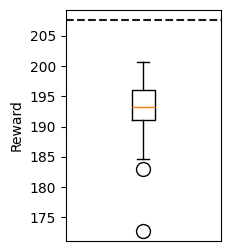

In [5]:
mean_rewards = np.array(data['rewards']).sum(axis = 2).mean(axis = 1)

plt.figure(figsize = (2, 3))
plt.boxplot(mean_rewards, flierprops = dict(marker = 'o', color = 'red', markersize = 10, linestyle = 'none'))
plt.axhline(max_means.mean(), color = 'black', linestyle = '--', alpha = 0.9)
plt.xticks([])
plt.xlabel(None)
plt.ylabel('Reward')
plt.show()
# plt.savefig('figures/performance.svg',  bbox_inches = 'tight')

In [6]:
print('Outlier:', np.argmin(mean_rewards))
delta_nll_deleted = np.delete(delta_nll, 7)

Outlier: 7


## Action correlations

In [7]:
max_time_lag = 100
time_lags = np.arange(1, max_time_lag)

correlations = np.zeros((num_net, max_time_lag - 1))

for id in range(num_net):
    correlations_net = np.zeros((num_simulation, len(time_lags)), dtype = float)

    action_seq_net = data['actions'][id]
    reward_seq_net = data['rewards'][id]

    for i in range(num_simulation):
        for l, lag in enumerate(time_lags):
            correlations_net[i, l] = np.mean([action_seq_net[i, _] == action_seq_net[i, _ - lag] for _ in range(lag, num_trials)])
    
    correlations[id] = correlations_net.mean(axis = 0)

correlations_deleted = np.delete(correlations, 7, axis = 0)

Plot of correlation between current and past choices in meta-RL agents.
Each line indicates an agent.ent.

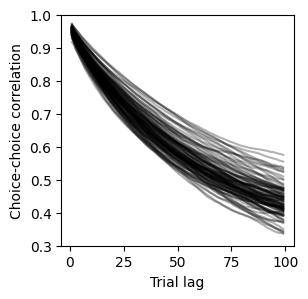

In [40]:
max_time_lag = 100
time_lags = np.arange(1, max_time_lag)

plt.figure(figsize = (3, 3))
plt.plot(time_lags, correlations_deleted.T, color = 'black', alpha = 0.3)
plt.xlabel('Trial lag')
plt.ylabel('Choice-choice correlation')
plt.ylim((0.3, 1))
plt.show()
# plt.savefig('figures/action_correlation1.svg',  bbox_inches = 'tight')

Better choice decorrelation ability (i.e., smaller choice-choice correlation) predicts
superior fits of the sampling model over the TD model among agents. The figure shows the results for trial lag = 5. Each
dot indicates an agent.

PearsonRResult(statistic=-0.43571975316155725, pvalue=6.5545347009021195e-06)


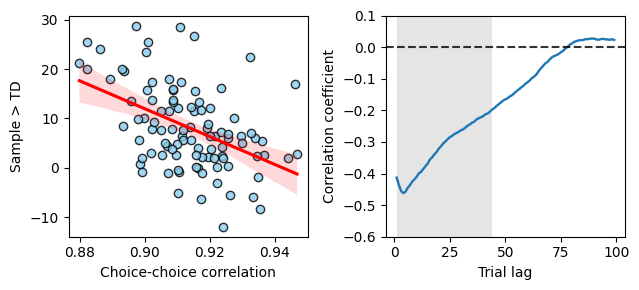

In [41]:
rs = np.array([])
ps = np.array([])
for l, lag in enumerate(time_lags):
    correlation_slice = np.array(correlations_deleted)[:, l]
    result = scipy.stats.pearsonr(delta_nll_deleted, correlation_slice)
    rs = np.append(rs, result[0])
    ps = np.append(ps, result[1])

plt.figure(figsize = (6.5, 3))

plt.subplot(1, 2, 1)
plt.scatter(np.array(correlations_deleted)[:, 3], delta_nll_deleted, color = '#88CCEE', edgecolors = 'black', alpha = 0.8)
sns.regplot(x = np.array(correlations_deleted)[:, 3], y = np.array(delta_nll_deleted), scatter = False, color = 'red')
plt.xticks(np.arange(0.88, 0.95, 0.02))
# plt.xlim((0.87, 0.95))
plt.xlabel('Choice-choice correlation')
plt.ylabel('Sample > TD')

sig_range = np.where(ps < 0.05)[0]
plt.subplot(1, 2, 2)
plt.plot(time_lags, rs, linewidth = 1.7)
plt.axhline(y = 0., color = 'k', linestyle = '--', alpha = 0.8)
plt.axvspan(time_lags[sig_range[0]], time_lags[sig_range[-1]], color = 'gray', alpha = 0.2, linewidth = 0)
plt.ylim((-0.6, 0.1))
plt.xlabel('Trial lag')
plt.ylabel('Correlation coefficient')

plt.tight_layout()
# plt.show()

print(scipy.stats.pearsonr(delta_nll_deleted, correlations_deleted[:, 1]))
# plt.savefig('figures/action_correlation2.svg',  bbox_inches = 'tight')

## Memory cell-action correlations

In [13]:
max_time_lag = 100
time_lags = np.arange(1, max_time_lag)

accuracies_cell = np.zeros((num_net, len(time_lags)))

num_component = 5
explained_variance_cell = np.zeros((num_net, num_component))

for id in range(num_net):

    action_seq_net = data['actions'][id] # (num_simulation, num_trials)
    reward_seq_net = data['rewards'][id] # (num_simulation, num_trials)
    cell_seq_net = data['cells'][id] # (num_simulation, num_trials, num_hidden)
    hidden_seq_net = data['hiddens'][id] # (num_simulation, num_trials, num_hidden)

    # PCA
    pca = PCA(n_components = num_component)
    reshaped_cell_seq_net = cell_seq_net.reshape(-1, num_hidden)
    pca_result = pca.fit_transform(reshaped_cell_seq_net)
    ld_cell_seq_net = pca_result.reshape(num_simulation, num_trials, num_component)
    explained_variance_cell[id, :] = pca.explained_variance_ratio_


    for l, lag in enumerate(time_lags):
        X = []
        Y = []

        for t in range(lag, num_trials):
            X.append(ld_cell_seq_net[:, t - lag, :])
            Y.append(action_seq_net[:, t])

        X = np.concatenate(X)
        Y = np.concatenate(Y)

        model = LogisticRegression(max_iter = 1000)
        model.fit(X, Y)
        predictions = model.predict(X)
        accuracy = accuracy_score(Y, predictions)
        
        accuracies_cell[id, l] = accuracy
    
accuracies_cell_deleted = np.delete(accuracies_cell, 7, axis = 0)
explained_variance_cell_deleted = np.delete(explained_variance_cell, 7, axis = 0)

Memory cell-choice correlation of meta-RL agents. Correlation between current choices and past memory
cells in meta-RL agents. Each line indicates an agent.

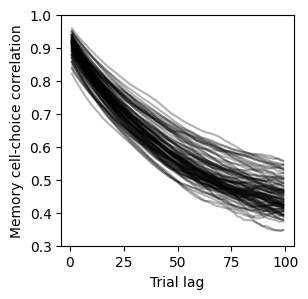

In [42]:
max_time_lag = 100
time_lags = np.arange(1, max_time_lag)

plt.figure(figsize = (3, 3))
plt.plot(time_lags, accuracies_cell_deleted.T, color = 'black', alpha = 0.3)
plt.xlabel('Trial lag')
plt.ylabel('Memory cell-choice correlation')
plt.ylim((0.3, 1))
plt.tight_layout()
plt.show()
# plt.savefig('figures/memory_correlation1.svg',  bbox_inches = 'tight')

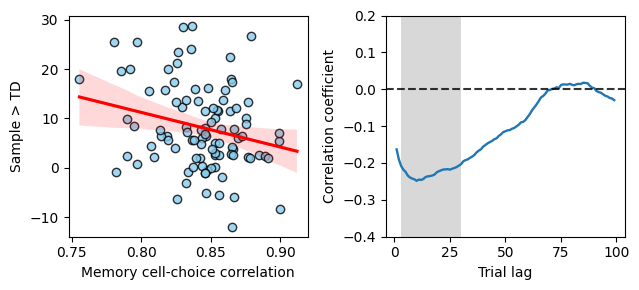

In [43]:
rs = np.array([])
ps = np.array([])
for l, lag in enumerate(time_lags):
    accuracies_slice = np.array(accuracies_cell_deleted)[:, l]
    result = scipy.stats.pearsonr(delta_nll_deleted, accuracies_slice)
    rs = np.append(rs, result[0])
    ps = np.append(ps, result[1])

plt.figure(figsize = (6.5, 3))

plt.subplot(1, 2, 1)
plt.scatter(accuracies_cell_deleted[:, 6], delta_nll_deleted, color = '#88CCEE', edgecolors = 'black', alpha = 0.8)
sns.regplot(x = accuracies_cell_deleted[:, 6], y = np.array(delta_nll_deleted), scatter = False, color = 'red')
plt.xlabel('Memory cell-choice correlation')
plt.ylabel('Sample > TD')

sig_range = np.where(ps < 0.05)[0]
plt.subplot(1, 2, 2)
plt.plot(time_lags, rs, linewidth = 1.7)
plt.axhline(y = 0., color = 'k', linestyle = '--', alpha = 0.8)
plt.axvspan(time_lags[sig_range[0]], time_lags[sig_range[-1]], color = 'gray', alpha = 0.3, linewidth = 0)
plt.ylim((-0.4, 0.2))
plt.xlabel('Trial lag')
plt.ylabel('Correlation coefficient')

plt.tight_layout()
# plt.show()
plt.savefig('figures/memory_correlation2.svg',  bbox_inches = 'tight')

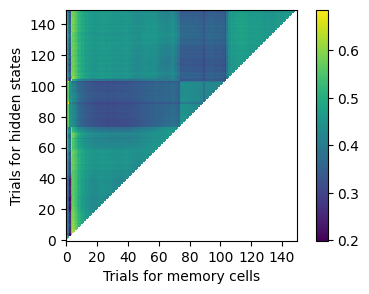

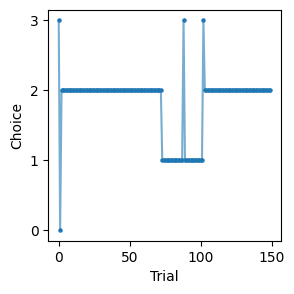

In [44]:
simulation_idx = 25
# 25

# Compute pairwise distances between representations in data1 and data2
distances = np.zeros((num_trials, num_trials)) * np.nan

for i in range(num_trials):
    for j in range(i + 1, num_trials):
        distances[j, i] = np.dot(cell_seq_net[simulation_idx, i, :], hidden_seq_net[simulation_idx, j, :]) / (np.linalg.norm(cell_seq_net[simulation_idx, i, :]) * np.linalg.norm(hidden_seq_net[simulation_idx, j, :]))
        # distances[j, i] = np.dot(cell_seq_net[simulation_idx, i, :], cell_seq_net[simulation_idx, j, :]) / (np.linalg.norm(cell_seq_net[simulation_idx, i, :]) * np.linalg.norm(cell_seq_net[simulation_idx, j, :]))


# Mask lower triangle values
distances = np.ma.masked_invalid(distances)

# Visualize the similarity matrix
plt.figure(figsize = (5, 3))
plt.imshow(distances, cmap = 'viridis', interpolation = 'nearest')
plt.colorbar()
plt.xticks(np.arange(0, 150, 20))
plt.yticks(np.arange(0, 150, 20))
plt.gca().invert_yaxis()  # Invert y-axis
plt.xlabel('Trials for memory cells')
plt.ylabel('Trials for hidden states')
plt.show()
# plt.savefig('figures/rsa1.svg', bbox_inches = 'tight')


plt.figure(figsize = (3, 3))
plt.plot(np.arange(num_trials), action_seq_net[simulation_idx, :], alpha = 0.6)
plt.scatter(np.arange(num_trials), action_seq_net[simulation_idx, :], s = 5)
plt.yticks([0, 1, 2, 3])
plt.xlabel('Trial')
plt.ylabel('Choice')
plt.show()
# plt.savefig('figures/rsa2.svg', bbox_inches = 'tight')

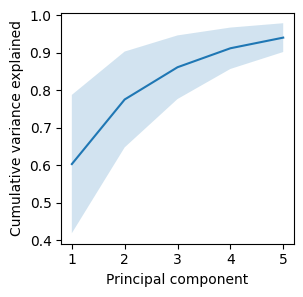

In [38]:
cumsum_explained_variance = np.cumsum(explained_variance_cell_deleted, axis = 1)
mean_explained_variance = np.mean(cumsum_explained_variance, axis = 0)
std_explained_variance = np.std(cumsum_explained_variance, axis = 0)

plt.figure(figsize = (3, 3))
plt.plot([1, 2, 3, 4, 5], mean_explained_variance)
plt.fill_between([1, 2, 3, 4, 5], mean_explained_variance - std_explained_variance, mean_explained_variance + std_explained_variance, alpha = 0.2)
plt.xlabel('Principal component')
plt.ylabel('Cumulative variance explained')
# plt.show()
plt.savefig('figures/pca.svg', bbox_inches = 'tight')